<a href="https://colab.research.google.com/github/Oliz888/DL_course/blob/main/chapter_linear-regression/linear-regression-scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==1.0.3


# Linear Regression Implementation from Scratch
:label:`sec_linear_scratch`

We are now ready to work through
a fully functioning implementation
of linear regression.
In this section,
(**we will implement the entire method from scratch,
including (i) the model; (ii) the loss function;
(iii) a minibatch stochastic gradient descent optimizer;
and (iv) the training function
that stitches all of these pieces together.**)
Finally, we will run our synthetic data generator
from :numref:`sec_synthetic-regression-data`
and apply our model
on the resulting dataset.
While modern deep learning frameworks
can automate nearly all of this work,
implementing things from scratch is the only way
to make sure that you really know what you are doing.
Moreover, when it is time to customize models,
defining our own layers or loss functions,
understanding how things work under the hood will prove handy.
In this section, we will rely only
on tensors and automatic differentiation.
Later, we will introduce a more concise implementation,
taking advantage of the bells and whistles of deep learning frameworks
while retaining the structure of what follows below.


In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l

## Defining the Model

[**Before we can begin optimizing our model's parameters**] by minibatch SGD,
(**we need to have some parameters in the first place.**)
In the following we initialize weights by drawing
random numbers from a normal distribution with mean 0
and a standard deviation of 0.01.
The magic number 0.01 often works well in practice,
but you can specify a different value
through the argument `sigma`.
Moreover we set the bias to 0.
Note that for object-oriented design
we add the code to the `__init__` method of a subclass of `d2l.Module` (introduced in :numref:`subsec_oo-design-models`).


In [3]:
class LinearRegressionScratch(d2l.Module):  #@save
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True) ##我们通过从均值为 0 且标准差为 0.01 的正态分布中抽取随机数来初始化权重。幻数 0.01 在实践中通常效果很好，但您可以通过参数 sigma 指定不同的值
        self.b = torch.zeros(1, requires_grad=True) ## 此外，我们将偏差设置为 0

Next we must [**define our model,
relating its input and parameters to its output.**]
Using the same notation as :eqref:`eq_linreg-y-vec`
for our linear model we simply take the matrix--vector product
of the input features $\mathbf{X}$
and the model weights $\mathbf{w}$,
and add the offset $b$ to each example.
The product $\mathbf{Xw}$ is a vector and $b$ is a scalar.
Because of the broadcasting mechanism
(see :numref:`subsec_broadcasting`),
when we add a vector and a scalar,
the scalar is added to each component of the vector.
The resulting `forward` method
is registered in the `LinearRegressionScratch` class
via `add_to_class` (introduced in :numref:`oo-design-utilities`).


In [4]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def forward(self, X):
    return torch.matmul(X, self.w) + self.b ## 乘积 Xw 是一个向量， 也是一个标量。由于广播机制（参见 Section 2.1.4），当我们添加 vector 和 scalar 时，标量会被添加到 vector 的每个分量中

## Defining the Loss Function

Since [**updating our model requires taking
the gradient of our loss function,**]
we ought to (**define the loss function first.**)
Here we use the squared loss function
in :eqref:`eq_mse`.
In the implementation, we need to transform the true value `y`
into the predicted value's shape `y_hat`.
The result returned by the following method
will also have the same shape as `y_hat`.
We also return the averaged loss value
among all examples in the minibatch.


In [5]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean()

    ## 在实现中，我们需要将 true 值 y 转换为预测值的形状 y_hat 。以下方法返回的结果也将具有与 y_hat . 相同的形状。

## Defining the Optimization Algorithm

As discussed in :numref:`sec_linear_regression`,
linear regression has a closed-form solution.
However, our goal here is to illustrate
how to train more general neural networks,
and that requires that we teach you
how to use minibatch SGD.
Hence we will take this opportunity
to introduce your first working example of SGD.
At each step, using a minibatch
randomly drawn from our dataset,
we estimate the gradient of the loss
with respect to the parameters.
Next, we update the parameters
in the direction that may reduce the loss.

The following code applies the update,
given a set of parameters, a learning rate `lr`.
Since our loss is computed as an average over the minibatch,
we do not need to adjust the learning rate against the batch size.
In later chapters we will investigate
how learning rates should be adjusted
for very large minibatches as they arise
in distributed large-scale learning.
For now, we can ignore this dependency.


We define our `SGD` class,
a subclass of `d2l.HyperParameters` (introduced in :numref:`oo-design-utilities`),
to have a similar API
as the built-in SGD optimizer.
We update the parameters in the `step` method.
The `zero_grad` method sets all gradients to 0,
which must be run before a backpropagation step.


In [6]:
class SGD(d2l.HyperParameters):          # ①  继承 d2l.HyperParameters → 可用 save_hyperparameters()
    """Minibatch stochastic gradient descent."""

    def __init__(self, params, lr):
        """
        params : 可迭代的张量 – 要更新的模型参数 (weights & biases 等)
        lr     : float          – 学习率 (learning-rate)
        """
        self.save_hyperparameters()      # ② 把 params / lr 自动存成 self.params, self.lr，并记录到 self.hparams

    # ------------------------------------------------------------
    # ③ 单步更新：θ ← θ − lr · ∇θ
    #    假设 .backward() 已经算好 param.grad
    # ------------------------------------------------------------
    def step(self):
        for param in self.params:        # 遍历所有待优化张量
            param -= self.lr * param.grad  # 原地更新：param = param - lr * grad

    # ------------------------------------------------------------
    # ④ 梯度清零：在下一次反向传播前必须把梯度设回 0
    # ------------------------------------------------------------
    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:   # 有些参数可能还没参与梯度计算
                param.grad.zero_()       # in-place 置零，省内存


`save_hyperparameters()`
自带「把建构子形参自动变成属性」的功能，省去 self.lr = lr、self.params = params 等样板写法。

`step()`
完成经典 SGD 更新公式 θ ← θ − α∇θ；这里没有 momentum、weight-decay 等额外机制，示范最朴素版本。

`param -= self.lr * param.grad `

就是在原地（in-place）把所有可訓練參數—including w、b、卷積核、BatchNorm scale/shift…—通通往「負梯度方向」移動一小步。細節拆開說：


 | 名稱           | 角色                                                                                                                               | 更新後變化                                       |
| ------------ | -------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------- |
| `param`      | 來自 `self.params`，通常是模型裡每一個 **`nn.Parameter`**：<br>· 線性層的 `weight`、`bias`<br>· Conv 層的 `weight`<br>· BatchNorm 的 `gamma`、`beta` … | 直接被覆寫成<br>`param ← param − lr · param.grad` |
| `lr`         | 學習率                                                                                                                              | 決定「一步走多遠」                                   |
| `param.grad` | 在 `loss.backward()` 之後由 Autograd 寫入的 **梯度張量**                                                                                    | 使用後仍保留；下批次前由 `zero_grad()` 清零               |






`zero_grad()`
训练循环中应在每个 mini-batch 的 loss.backward() 之后、下一次前调用，避免梯度累积。

We next define the `configure_optimizers` method, which returns an instance of the `SGD` class.


In [7]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

| 步驟                     | 發生什麼事                             | `param.grad` 內容         |
| ---------------------- | --------------------------------- | ----------------------- |
| 1. 前向傳播                | `loss = model(X)` → 標量            | 尚未建立，為 `None`           |
| 2. 反向傳播                | `loss.backward()`                 | **寫入梯度**，形狀與 `param` 相同 |
| 3. `optim.step()`      | `param ← param − lr × param.grad` | 還是舊梯度，不會自動清零            |
| 4. `optim.zero_grad()` | `param.grad.zero_()`              | 回到 0，等下一輪再填新梯度          |


## Training

Now that we have all of the parts in place
(parameters, loss function, model, and optimizer),
we are ready to [**implement the main training loop.**]
It is crucial that you understand this code fully
since you will employ similar training loops
for every other deep learning model
covered in this book.
In each *epoch*, we iterate through
the entire training dataset,
passing once through every example
(assuming that the number of examples
is divisible by the batch size).
In each *iteration*, we grab a minibatch of training examples,
and compute its loss through the model's `training_step` method.
Then we compute the gradients with respect to each parameter.
Finally, we will call the optimization algorithm
to update the model parameters.
In summary, we will execute the following loop:

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

Recall that the synthetic regression dataset
that we generated in :numref:``sec_synthetic-regression-data``
does not provide a validation dataset.
In most cases, however,
we will want a validation dataset
to measure our model quality.
Here we pass the validation dataloader
once in each epoch to measure the model performance.
Following our object-oriented design,
the `prepare_batch` and `fit_epoch` methods
are registered in the `d2l.Trainer` class
(introduced in :numref:`oo-design-training`).


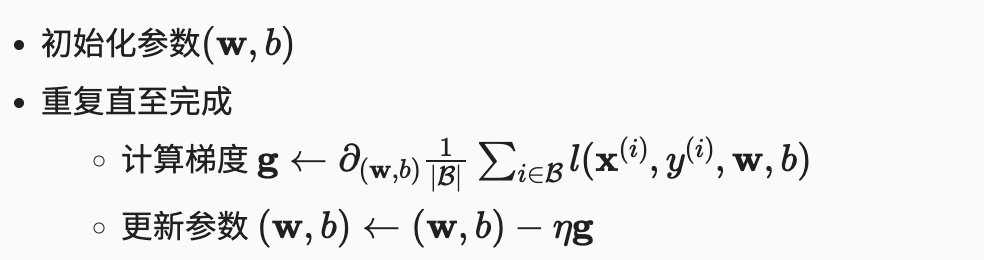

1 · 為何要「算梯度 → 反方向走」？
把損失函數
𝐿
(
𝑤
,
𝑏
)
L(w,b) 想成一座起伏的地形──
高度 = 誤差，平地 = 0 誤差。我們手上只有當前位置
(
𝑤
,
𝑏
)
(w,b) 一個點的資訊。

梯度
∇
𝐿
∇L 就是這點「最陡上坡」的向量；
往它的 反方向 走最能讓海拔（損失）快速下降。

學習率
𝜂
η 決定一步跨多遠：
太大像跳崖，太小像螞蟻爬山。

迷你批次平均 先把同批資料的損失取平均，
可以讓方向比較穩，不會被單一樣本的噪聲牽著跑。

這就是公式背後的直觀圖像：

「在當下這一小批資料上，找到下降最快的方向，
然後沿那方向走一小步。」

***NOTE: Python 中的「decorator（装饰器）」是什么？ ***

# **1 语法**
装饰器就是一个 “拿函数（或类）当输入，又返回一个新函数（或类）” 的 高阶函数。
在语法上用 @名字 前缀贴在目标上，相当于给目标套一层包装，在不改动原始代码的情况下添加额外行为。

# **2 为什么要用它？**
| 场景                  | 传统写法                                       | 用装饰器后                               |
| ------------------- | ------------------------------------------ | ----------------------------------- |
| 函数调用前后插日志           | 在每个函数里手动写 `print("enter")`、`print("exit")` | 定义一次 `@log` 装饰器，全局复用                |
| 缓存/备忘录（memoization） | 手动写字典存结果                                   | `@functools.lru_cache` 一行解决         |
| Django 路由或 Flask 路由 | 单独注册 URL → 视图函数                            | `@app.route('/path')` 贴在函数头上        |
| 教学示例中动态给类加方法        | 修改类源码                                      | `@d2l.add_to_class(SomeClass)` 直接注入 |

# **3 · 最小可运行示例**
3.1 函数装饰器
```
def log(func):                       # ← 装饰器本身
    def wrapper(*args, **kwargs):    #   内层包装函数
        print(f"[LOG] call {func.__name__}")
        return func(*args, **kwargs) #   调用原函数
    return wrapper                   # ← 把包装函数返回

@log
def add(a, b):
    return a + b

print(add(2, 3))
```
output
```
[LOG] call add
5
```
3.2 带参数的装饰器
```
def repeat(n):                       # 先接收参数
    def deco(func):
        def wrapper(*args, **kwargs):
            for _ in range(n):
                func(*args, **kwargs)
        return wrapper
    return deco

@repeat(3)       # 执行同一个函数 3 次
def hello():
    print("Hi!")

hello()
```

# **4 · 内置常见装饰器**
| 装饰器                | 作用                                       |
| ------------------ | ---------------------------------------- |
| `@staticmethod`    | 在类里定义“静态函数”（不带 `self`）                   |
| `@classmethod`     | 第一个参数是 `cls` 而非 `self`                   |
| `@property`        | 把方法伪装成属性：`obj.length` 而不是 `obj.length()` |
| `@functools.wraps` | 保留被装饰函数的元信息（`__name__`, `__doc__` 等）     |




In [3]:
def log(func):                       # ← 装饰器本身
    def wrapper(*args, **kwargs):    #   内层包装函数
        print(f"[LOG] call {func.__name__}")
        return func(*args, **kwargs) #   调用原函数
    return wrapper                   # ← 把包装函数返回

@log
def add(a, b):
    return a + b

print(add(2, 3))

[LOG] call add
5


In [1]:
def repeat(n):                       # 先接收参数
    def deco(func):
        def wrapper(*args, **kwargs):
            for _ in range(n):
                func(*args, **kwargs)
        return wrapper
    return deco

@repeat(3)       # 执行同一个函数 3 次
def hello():
    print("Hi!")

hello()

Hi!
Hi!
Hi!


In [8]:
@d2l.add_to_class(d2l.Trainer)   # ①
def prepare_batch(self, batch):  # ②
    return batch                 # ③

| 行號                                  | 作用                                                                                                                                              | 為何要這樣做                                                                                                            |
| ----------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------- |
| ① `@d2l.add_to_class(d2l.Trainer)`  | 這是一個 **裝飾器 (decorator)**。D2L 定義了 `add_to_class(cls)` 這個函式，用來把下面緊跟的函式 **掛到指定的類別** (`cls`) 上。等號意義：<br>`d2l.Trainer.prepare_batch = prepare_batch` | 這樣就不必去修改 `Trainer` 原始碼，就可以「熱插拔」加新方法。Notebook/教學常用這招來分段展示程式。                                                       |
| ② `def prepare_batch(self, batch):` | 定義一個方法。<br>`self` → `Trainer` 物件本身；<br>`batch` → DataLoader 迭代到的 mini-batch (任意型別)。                                                             | 提供 **批次前處理的掛鉤 (hook)**。之後 `Trainer` 內部在呼叫 `model.training_step(...)` 之前，會先執行 `batch = self.prepare_batch(batch)`。 |
| ③ `return batch`                    | 預設什麼都不做，原封不動把 batch 傳回去。                                                                                                                        | **方便覆寫**：如果你需要把張量搬到 GPU、做 dtype 轉換、資料增強 … 只要在 Notebook 重新執行另一版 `prepare_batch`（同名覆寫）即可。                           |


In [ ]:
# 範例：把 batch 搬到 GPU
device = torch.device('cuda:0')

@d2l.add_to_class(d2l.Trainer)
def prepare_batch(self, batch):
    # 假設 batch 是 (X, y)
    X, y = batch
    return X.to(device), y.to(device)

# **Linear regression model training from scratch**

1. Put the model in training mode – turns on Dropout, BatchNorm statistics, etc.

2. Loop over every mini-batch of the training data

 1. Forward pass (training_step) → loss

  2. zero_grad() – clear last batch’s gradients

  3. Back-prop (loss.backward()) – populate param.grad

  4. (Optional) clip overly large gradients

  5. Optimiser step() – update the weights

  6. Advance the training-batch counter (for progress-plots)

3. If no validation set, stop here.

4. Switch to eval mode – Dropout off, BatchNorm frozen.

5. Loop over validation batches
Only forward passes (validation_step); no gradient tracking.

6. Advance the validation-batch counter after each batch.

7. Return to the caller (Trainer.fit) so the next epoch can start.

In [11]:
@d2l.add_to_class(d2l.Trainer)   # <-- ❶ decorator：把下面函式注入 Trainer
def fit_epoch(self):            #       等同寫在 Trainer 類裡
    # ---------- A. TRAINING PHASE ---------------------------------
    self.model.train()          # ❷ 打開 Dropout / BN 的“訓練模式”

    for batch in self.train_dataloader:      # ❸ 逐 mini-batch
        # ① forward + loss（由 model.training_step 實作）
        loss = self.model.training_step(self.prepare_batch(batch))

        self.optim.zero_grad()              # ② 清掉上一批的梯度

        with torch.no_grad():               # ③ 不讓 autograd 記錄優化器步驟
            loss.backward()                 # ②.5 反向傳播 → 填 param.grad

            # ④ 梯度裁剪（防爆梯）；0 代表不啟用
            if self.gradient_clip_val > 0:
                self.clip_gradients(self.gradient_clip_val, self.model)

            self.optim.step()               # ⑤ SGD / Adam 更新權重

        self.train_batch_idx += 1           # ⑥ 給 ProgressBoard 畫曲線用
    # ----------------------------------------------------------------

    if self.val_dataloader is None:         # ❸ 沒驗證集就直接結束本 epoch
        return

    # ---------- B. VALIDATION PHASE ---------------------------------
    self.model.eval()                       # ❹ 切成 evaluation mode
    for batch in self.val_dataloader:
        with torch.no_grad():               # 只做前向，不要算梯度
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1             # ⑦ 畫圖／記錄


重要语法 & 设计要点

| 符号 / 调用                                       | 说明                                                                                                                   |
| --------------------------------------------- | -------------------------------------------------------------------------------------------------------------------- |
| `@d2l.add_to_class(ClassName)`                | 把下面定义的函数当作方法动态挂到 `ClassName`；无需改动原始源码。                                                                               |
| `self.model.train()` vs `self.model.eval()`   | 切换 PyTorch 的两种模式：<br>• `train()` 启用 Dropout、让 BatchNorm 使用 batch-stat。<br>• `eval()` 关闭 Dropout、BatchNorm 用移动平均。     |
| `with torch.no_grad():`                       | 临时关闭 autograd：<br>• **训练阶段**：包住 `loss.backward()` 之后的 *梯度处理*，防止 `step()` 的张量操作被记录。<br>• **验证阶段**：整个前向传递都无需梯度，可省显存加速。 |
| `self.prepare_batch(batch)`                   | 预处理钩子：默认原样返回；用户可重写以搬到 GPU、改变 dtype、数据增强等。                                                                            |
| `gradient_clip_val`                           | >0 时调用 `clip_gradients()` 限制 `‖grad‖`，避免梯度爆炸。                                                                        |
| `self.train_batch_idx` / `self.val_batch_idx` | 记录已处理多少批；`model.plot()` 用来把横轴映射到 *epoch 进度*。                                                                         |


这个 `fit_epoch()` 让 Trainer 只管“宏观流程”，而把 损失计算 / 指标记录 交给模型侧的 `training_step()`、`validation_step()`。
如此解耦后，你可以自由替换模型、优化器或批次预处理，而不必改动 epoch 循环骨架。

# `.()train` 打開DROP OUT/BatchNorm 的訓練模式


| 層別            | `.train()`（訓練模式）                                                                         | `.eval()`（推論／驗證模式）           |
| ------------- | ---------------------------------------------------------------------------------------- | ---------------------------- |
| **Dropout**   | 隨機把輸出神經元以機率 *p* 置 0，再把剩餘值放大 $1/(1-p)$ 以保期望不變。<br>→ 每次 forward 都在“亂遮”，等於做集合模型 (ensemble)。 | 完全 **不遮**，直接把輸入原樣輸出。         |
| **BatchNorm** | 1️⃣ 用當前 mini-batch 的均值/方差來標準化；<br>2️⃣ 同時更新「滑動平均統計」(running mean/var)。                    | 只用 **那份滑動平均** 來標準化，保證輸入分佈固定。 |


PyTorch 透過 module.training 這個布林旗標控制行為：
- 呼叫 model.train() → 把所有子模組的 training=True。
- 呼叫 model.eval() → 把所有子模組的 training=False。


為什麼這麼設計？
- Dropout 在訓練時需要隨機性來防止過擬合；推論時若仍亂遮會降低精度，所以必須關閉。
- BatchNorm 在訓練時用批次統計比較準；然而推論階段只有一張圖片（或少量樣本），因此改用整個訓練過程累積的滑動平均，讓輸入分佈穩定一致。


超小實驗：看 Dropout 輸出差異


```
import torch, torch.nn as nn

m = nn.Dropout(p=0.5)
x = torch.ones(5)

# 訓練模式
m.train(); print("train:", m(x))
# 推論模式
m.eval();  print("eval :", m(x))

```

possible output

```
train: tensor([2., 0., 2., 0., 0.])   # 隨機遮且放大
eval : tensor([1., 1., 1., 1., 1.])   # 完全不遮

```





```
PyTorch   <-- 定義了 nn.Module.train() / eval()
   ▲
   │              (Trainer 只是“使用”它)
d2l.Trainer  ──►  model.train()   或   model.eval()
```
1. “打開”/“關閉” 指的是 nn.Module.train() / eval() 切換了內部布林值 module.training
2. 每個像 Dropout, BatchNorm 的子層在 forward() 時都會查 self.training 决定要做哪種運算。
3. Trainer 只是負責在合適時機呼叫；並不是它繼承了什麼特殊特性，而是 利用了 PyTorch 自帶的機制。

# Simulation

Below is a “table-top simulation” of what fit_epoch() really does, using the smallest concrete setup I could think of:


| component                      | toy choice                                                                                                          |
| ------------------------------ | ------------------------------------------------------------------------------------------------------------------- |
| Model (`self.model`)           | ŷ = w · x + b   (one weight, one bias)                                                                             |
| Loss used in `training_step()` | **MSE**: ½ (ŷ − y)²                                                                                                |
| Optimizer (`self.optim`)       | our earlier hand-rolled `SGD` with lr = 0.1                                                                         |
| Gradient-clip setting          | `gradient_clip_val = 1.0` (so we can see it trigger)                                                                |
| Mini-batch loaders             | **train**: 4 samples, batch size = 2  → 2 batches/epoch  <br> **val**  : 2 samples, batch size = 2  → 1 batch/epoch |



0. Initial state

```
w = 2.0         b = 0.0
train data  (x, y): (1, 3) , (2, 5) , (3, 7) , (4,  9)
val   data  (x, y): (0, 1) , (5,11)
train_batch_idx = val_batch_idx = 0
```
(The target rule is “y = 2x + 1”, so参数一开始是错的。)


1. Training phase

▸ Batch 1 (x = [1,2], y = [3,5])

| code line                         | what happens                                                                            | tiny numbers                                                        |
| --------------------------------- | --------------------------------------------------------------------------------------- | ------------------------------------------------------------------- |
| `loss = model.training_step(...)` | Forward ⟶ ŷ = \[2·1+0, 2·2+0] = \[2, 4].<br>Loss = ½\[(2−3)² + (4−5)²] = ½\[1 + 1] = 1 | `loss = 1`                                                          |
| `optim.zero_grad()`               | 梯度清零                                                                                    | w\.grad = b.grad = 0                                                |
| `loss.backward()`                 | Compute gradients w\.r.t current batch                                                  | <br>∂L/∂w = ∑(ŷ−y)x = (2−3)·1+(4−5)·2 = −3<br>∂L/∂b = ∑(ŷ−y) = −2 |
| clip? (`val=1.0`)                 | ‖g‖ ≈ √(9+4)=3.6 > 1 → **scale** gradients by 1/3.6 ≈ 0.28                              | w\.grad = −3×0.28 ≈ −0.84<br>b.grad ≈ −0.56                         |
| `optim.step()`                    | w ← 2.0 − 0.1·(−0.84) = 2.084<br>b ← 0.0 − 0.1·(−0.56) = 0.056                          |                                                                     |
| `train_batch_idx += 1`            | for progress plotting                                                                   | train\_batch\_idx = 1                                               |


▸ Batch 2 (x = [3,4], y = [7,9])


```
w ≈ 2.19 ,  b ≈ 0.11
train_batch_idx = 2
```



2. Validation phase (self.model.eval())

`torch.no_grad()` ⟹ 只前向、不算梯度。

```
ŷ = [0.11,  2.19·5+0.11 ≈ 11.06]
loss = ½[(0.11−1)² + (11.06−11)²] ≈ 0.40
val_batch_idx = 1
```

3 · Epoch completed – visible side-effects



| object                 | value after `fit_epoch()`                                                                                                                                             |
| ---------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `self.model`           | weights updated (w≈2.19, b≈0.11)                                                                                                                                      |
| `self.train_batch_idx` | 2                                                                                                                                                                     |
| `self.val_batch_idx`   | 1                                                                                                                                                                     |
| `ProgressBoard`        | already has the points to draw: <br>- training-loss at x = 0 → 1 (batch 1 halfway),<br>- another at 1 → ( batch 2 ),<br>- validation-loss at integer epoch tick x = 1 |




Code-structure recap (why the lines are arranged like that)
mode switch (train() / eval())
Guarantees Dropout & BatchNorm behave correctly.

for batch in loader:
Drives the optimizer step-by-step; everything needing gradients stays outside the no_grad() context.

Two gradient-related helpers

zero_grad() – prevent gradient accumulation across batches.

gradient clipping – optional safety valve.

Separate validation loop under no_grad()
Keeps memory low and inference faster; never alters weights.

That’s the concrete life of one tiny epoch behind those 15 lines of code. Feel free to tweak the numbers, batch size, or learning-rate on paper (or in a notebook) to see how each piece reacts!







# Gradient Clipping


 · The problem — “exploding gradients”
In deep or recurrent networks the back-propagated gradients can occasionally become huge (100 ×, 1000 × larger than usual).
When that happens:

One SGD step blasts the weights far off the useful part of the loss surface.

The loss becomes nan or the model diverges instead of learning.

Think of climbing down a mountain: if every so often the compass arrow jumps to “run 5 km west!” you’ll overshoot the valley.


2 · Gradient clipping = “speed-limit” for that arrow
Before the optimiser updates the parameters we inspect the gradient vector
and, if it is above a preset threshold, shrink it:


We are almost ready to train the model,
but first we need some training data.
Here we use the `SyntheticRegressionData` class
and pass in some ground truth parameters.
Then we train our model with
the learning rate `lr=0.03`
and set `max_epochs=3`.
Note that in general, both the number of epochs
and the learning rate are hyperparameters.
In general, setting hyperparameters is tricky
and we will usually want to use a three-way split,
one set for training,
a second for hyperparameter selection,
and the third reserved for the final evaluation.
We elide these details for now but will revise them
later.


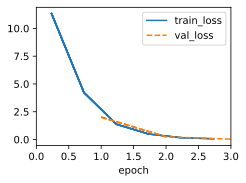

In [10]:
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

Because we synthesized the dataset ourselves,
we know precisely what the true parameters are.
Thus, we can [**evaluate our success in training
by comparing the true parameters
with those that we learned**] through our training loop.
Indeed they turn out to be very close to each other.


In [12]:
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([ 0.0078, -0.1416])
error in estimating b: tensor([0.2057])


We should not take the ability to exactly recover
the ground truth parameters for granted.
In general, for deep models unique solutions
for the parameters do not exist,
and even for linear models,
exactly recovering the parameters
is only possible when no feature
is linearly dependent on the others.
However, in machine learning,
we are often less concerned
with recovering true underlying parameters,
but rather with parameters
that lead to highly accurate prediction :cite:`Vapnik.1992`.
Fortunately, even on difficult optimization problems,
stochastic gradient descent can often find remarkably good solutions,
owing partly to the fact that, for deep networks,
there exist many configurations of the parameters
that lead to highly accurate prediction.


## Summary

In this section, we took a significant step
towards designing deep learning systems
by implementing a fully functional
neural network model and training loop.
In this process, we built a data loader,
a model, a loss function, an optimization procedure,
and a visualization and monitoring tool.
We did this by composing a Python object
that contains all relevant components for training a model.
While this is not yet a professional-grade implementation
it is perfectly functional and code like this
could already help you to solve small problems quickly.
In the coming sections, we will see how to do this
both *more concisely* (avoiding boilerplate code)
and *more efficiently* (using our GPUs to their full potential).



## Exercises

1. What would happen if we were to initialize the weights to zero. Would the algorithm still work? What if we
   initialized the parameters with variance $1000$ rather than $0.01$?
1. Assume that you are [Georg Simon Ohm](https://en.wikipedia.org/wiki/Georg_Ohm) trying to come up
   with a model for resistance that relates voltage and current. Can you use automatic
   differentiation to learn the parameters of your model?
1. Can you use [Planck's Law](https://en.wikipedia.org/wiki/Planck%27s_law) to determine the temperature of an object
   using spectral energy density? For reference, the spectral density $B$ of radiation emanating from a black body is
   $B(\lambda, T) = \frac{2 hc^2}{\lambda^5} \cdot \left(\exp \frac{h c}{\lambda k T} - 1\right)^{-1}$. Here
   $\lambda$ is the wavelength, $T$ is the temperature, $c$ is the speed of light, $h$ is Planck's constant, and $k$ is the
   Boltzmann constant. You measure the energy for different wavelengths $\lambda$ and you now need to fit the spectral
   density curve to Planck's law.
1. What are the problems you might encounter if you wanted to compute the second derivatives of the loss? How would
   you fix them?
1. Why is the `reshape` method needed in the `loss` function?
1. Experiment using different learning rates to find out how quickly the loss function value drops. Can you reduce the
   error by increasing the number of epochs of training?
1. If the number of examples cannot be divided by the batch size, what happens to `data_iter` at the end of an epoch?
1. Try implementing a different loss function, such as the absolute value loss `(y_hat - d2l.reshape(y, y_hat.shape)).abs().sum()`.
    1. Check what happens for regular data.
    1. Check whether there is a difference in behavior if you actively perturb some entries, such as $y_5 = 10000$, of $\mathbf{y}$.
    1. Can you think of a cheap solution for combining the best aspects of squared loss and absolute value loss?
       Hint: how can you avoid really large gradient values?
1. Why do we need to reshuffle the dataset? Can you design a case where a maliciously constructed dataset would break the optimization algorithm otherwise?


[Discussions](https://discuss.d2l.ai/t/43)


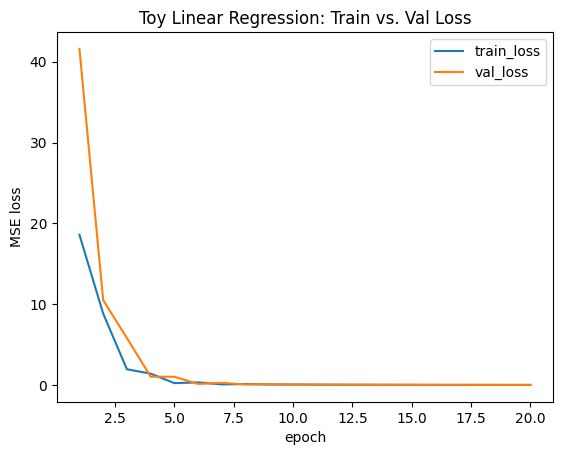

Final learned parameters: w = 1.993, b = 1.094
Train losses: [18.582489013671875, 8.832290291786194, 1.942601501941681, 1.4012233465909958, 0.22970763593912125, 0.31822398910298944, 0.0704224593937397, 0.11399603495374322, 0.047792624682188034, 0.056532968766987324, 0.0341822374612093, 0.03268352244049311, 0.023237645626068115, 0.020108381053432822, 0.01531539298593998, 0.012685640715062618, 0.009948304621502757, 0.008086183341220021, 0.006420700927264988, 0.005176828126423061]
Val losses  : [41.58644104003906, 10.498806953430176, 5.804066181182861, 1.0287829637527466, 1.0134309530258179, 0.127895787358284, 0.260542094707489, 0.057351820170879364, 0.10179562866687775, 0.04427769035100937, 0.052270110696554184, 0.032151900231838226, 0.03054586797952652, 0.02186545729637146, 0.018855314701795578, 0.014400227926671505, 0.011908384971320629, 0.009349538013339043, 0.007593897171318531, 0.006032793782651424]


In [3]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# ---------- 1. Toy dataset ----------
X_train = torch.tensor([[1.], [2.], [3.], [4.]])
y_train = torch.tensor([[3.], [5.], [7.], [9.]])  # true rule: y = 2x + 1
X_val   = torch.tensor([[0.], [5.]])
y_val   = torch.tensor([[1.], [11.]])

# train_loader = [(X_train[:2], y_train[:2]),  ## 第一個mini-batch: 索引0，1 -> 	[[1.],[2.]]
#  (X_train[2:], y_train[2:])] ## 第二個mini-batch 索引2，3 -> 	[[3.],[4.]]
# val_loader   = [(X_val, y_val)]

train_loader = DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=2,
    shuffle=True
)

# ---------- 2. Tiny linear model ----------
model = nn.Linear(1, 1)  # weight & bias

# ---------- 3. Optimizer ----------
lr = 0.1
optim = torch.optim.SGD(model.parameters(), lr=lr)

# ---------- 4. Training loop ----------
train_losses, val_losses = [], []
epochs = 20
for epoch in range(epochs):
    # ---- training phase ----
    model.train()
    epoch_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optim.zero_grad()
        y_hat = model(X_batch)
        loss = nn.functional.mse_loss(y_hat, y_batch)
        loss.backward()
        optim.step()
        epoch_train_loss += loss.item()
    train_losses.append(epoch_train_loss / len(train_loader))

    # ---- validation phase ----
    model.eval()
    with torch.no_grad():
        Xb, yb = val_loader[0]
        val_loss = nn.functional.mse_loss(model(Xb), yb).item()
    val_losses.append(val_loss)

# ---------- 5. Plot ----------
plt.plot(range(1, epochs+1), train_losses, label="train_loss")
plt.plot(range(1, epochs+1), val_losses,  label="val_loss")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title("Toy Linear Regression: Train vs. Val Loss")
plt.legend()
plt.show()

# ---------- 6. Print final parameters ----------
w = model.weight.item()
b = model.bias.item()
print(f"Final learned parameters: w = {w:.3f}, b = {b:.3f}")
print("Train losses:", train_losses)
print("Val losses  :", val_losses)


| Family                     | PyTorch class                                                     | One-line algorithm (update for parameter **θ**)                                                   | When it helps                                                 |
| -------------------------- | ----------------------------------------------------------------- | ------------------------------------------------------------------------------------------------- | ------------------------------------------------------------- |
| **Plain & momentum SGD**   | `SGD(lr)`<br>`SGD(lr, momentum=0.9)`<br>`SGD(..., nesterov=True)` | SGD: θ ← θ − η g<br>Momentum: v ← μ v + g; θ ← θ − η v<br>Nesterov: look-ahead gradient           | Small nets, good baselines; momentum often beats vanilla.     |
| **Adaptive‐learning-rate** | `Adagrad`                                                         | Accumulate **G ← G+g²**; θ ← θ − η g/√G                                                           | Sparse features, e.g. NLP with huge vocab.                    |
|                            | `RMSprop`                                                         | E\[g²] ← ρ E\[g²]+(1−ρ)g²; θ ← θ − η g/√E\[g²]                                                    | RNNs, non-stationary problems.                                |
|                            | `Adadelta`                                                        | Similar to RMSprop but removes explicit η; units-free.                                            | Rare today; legacy alt to RMSprop.                            |
| **Adam family**            | `Adam`                                                            | m←β₁m+(1−β₁)g; v←β₂v+(1−β₂)g²; ̂m=m/(1−β₁ᵗ); ̂v=v/(1−β₂ᵗ);   θ ← θ − η ̂m/√̂v                     | “Default” for deep nets; fast, robust.                        |
|                            | `AdamW`                                                           | Same as Adam **but** weight-decay done as θ←θ−η λ θ (decoupled). Recommended for transformers/CV. | Prevents the Adam–L2 coupling that hurts generalization.      |
|                            | `RAdam`                                                           | Adam + variance rectification; smooths early steps.                                               | Often removes need for warm-up.                               |
|                            | `NAdam`                                                           | Adam + Nesterov momentum.                                                                         | Slight gains in some NLP tasks.                               |
|                            | `Adamax`                                                          | Adam with ∞-norm (max) denominator (v∞).                                                          | Very large learning rates; mostly historical.                 |
|                            | `SparseAdam`                                                      | Adam variant that updates only non-zero indices.                                                  | Sparse embedding tables.                                      |
| **Second-order / quasi**   | `LBFGS`                                                           | Approximates inverse Hessian, line-search each step.                                              | Small models w/ few params; offline batch optimisation.       |
| **Sign-only**              | `Rprop`                                                           | θ ← θ − η sign(g); step-size η adapts per-param.                                                  | Traditional feed-forward nets; insensitive to gradient scale. |
| **Averaged**               | `ASGD`                                                            | SGD + Polyak/Ruppert averaging of weights.                                                        | Theoretically sound for convex problems.                      |
